In [2]:
import glob
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ase.io import read as read_xyz
from dscribe.descriptors import SOAP
from astartes import train_test_split

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV

from tqdm import tqdm
from paretoset import paretoset
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [3]:
RANDOM_SEED = 20

## Data Loading

In [10]:
structures = [read_xyz(x) for x in glob.glob("../data/raw/*.xyz")]
energy_levels = np.array([float(list(x.info.keys())[0]) for x in structures])

len(structures)

999

## Cross Validation

In [11]:
def get_model(model_name: str, pca_components: int):
    if model_name == "extra-trees":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", ExtraTreesRegressor(max_depth=10, random_state=RANDOM_SEED))
        ])
    elif model_name == "xgboost":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", XGBRegressor(max_depth=10, random_state=RANDOM_SEED))
        ])
    elif model_name == "lightgbm":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", LGBMRegressor(verbose=-1, max_depth=10, random_state=RANDOM_SEED))
        ])
    elif model_name == "stacking":
        return Pipeline(steps=[
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=pca_components)),
            ("reg", StackingRegressor(
                # final_estimator=LinearRegression(),
                estimators=[
                    ("etr", ExtraTreesRegressor(max_depth=10, random_state=RANDOM_SEED)), 
                    ("xgb", XGBRegressor(max_depth=10, random_state=RANDOM_SEED)), 
                    ("lgb", LGBMRegressor(verbose=-1, max_depth=10, random_state=RANDOM_SEED))
                ]
            ))
        ])
    
    raise ValueError("Unknown model name!")

In [12]:
param_space = list(ParameterGrid({
    "n_max": range(1, 11),
    "l_max": range(1, 11)
}))

len(param_space)

100

In [14]:
results = []

with warnings.catch_warnings(action="ignore"):
    for param in (pbar := tqdm(param_space)):
        soap = SOAP(
            r_cut=5,
            n_max=param["n_max"],
            l_max=param["l_max"],
            species=["Au"],
            periodic=False,
            average="outer",
            sparse=False
        )

        X = soap.create(structures, n_jobs=2)
        y = energy_levels.copy()

        # ignore test set
        X_train, _, y_train, _ = train_test_split(X, y, sampler="random", train_size=0.80, random_state=21)

        pca = PCA(n_components=min(X.shape[1], 15)).fit(StandardScaler().fit_transform(X))
        num_pc = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1

        cv = KFold(n_splits=5, shuffle=True, random_state=21)
        for i, (train_index, val_index) in enumerate(cv.split(X, y)):
            X_train, y_train = X[train_index], y[train_index]
            X_val, y_val = X[val_index], y[val_index]

            for model_name in ["extra-trees", "xgboost", "lightgbm", "stacking"]:
                pbar.set_description_str(f"Fold: {i+1} - Model: {model_name}")

                model = get_model(model_name, num_pc)
                model.fit(X_train, y_train)

                y_preds = model.predict(X_val)
                results.append({
                    "fold": i,
                    "model_name": model_name,
                    **param,
                    "num_desc": X.shape[1],
                    "pc": num_pc,
                    "r2": r2_score(y_val, y_preds),
                    "mae": mean_absolute_error(y_val, y_preds),
                    "rmse": root_mean_squared_error(y_val, y_preds),
                })

Fold: 5 - Model: stacking: 100%|██████████| 100/100 [21:14<00:00, 12.75s/it]  


## Analysis

In [15]:
df_results = pd.DataFrame(results)
df_results.to_csv("../data/soap-grid_search.csv", index=None)

df_results.head()

,fold,model_name,l_max,n_max,num_desc,pc,r2,mae,rmse
0,0,extra-trees,1,1,2,1,0.617072,1.321873,1.774705
1,0,xgboost,1,1,2,1,0.582384,1.366470,1.853344
2,0,lightgbm,1,1,2,1,0.643561,1.316778,1.712222
3,0,stacking,1,1,2,1,0.628309,1.308048,1.748472
4,1,extra-trees,1,1,2,1,0.621344,1.309640,1.728597


In [16]:
df_summary = df_results[["model_name", "n_max", "l_max", "mae", "rmse", "r2"]] \
    .groupby(["model_name", "n_max", "l_max"]) \
    .mean() \
    .reset_index() \
    .drop(columns=["model_name"])

df_summary.head()

,n_max,l_max,mae,rmse,r2
0,1,1,1.250513,1.679013,0.656630
1,1,2,0.803099,1.179380,0.830710
2,1,3,0.634746,1.001483,0.877273
3,1,4,0.524671,0.770752,0.927463
4,1,5,0.529263,0.778760,0.925904


In [17]:
mask = paretoset(df_summary, sense=["min", "min", "min", "min", "max"])

dd = df_summary[mask].sort_values("r2", ascending=False).round(4)
dd.to_csv("../data/soap-skyline.csv", index=None)

dd.head()

,n_max,l_max,mae,rmse,r2
206,1,7,0.4459,0.6575,0.9470
208,1,9,0.4401,0.6614,0.9460
203,1,4,0.5314,0.7630,0.9289
204,1,5,0.5254,0.7672,0.9280
3,1,4,0.5247,0.7708,0.9275


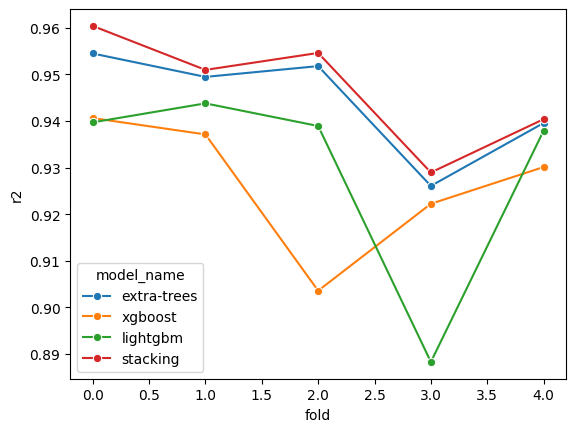

In [20]:
dd = df_results[(df_results["l_max"] == 7) & (df_results["n_max"] == 1)]

sns.lineplot(dd, x="fold", y="r2", hue="model_name", marker="o")

plt.show()